In [165]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, LabelBinarizer
from pandas.plotting import scatter_matrix
from helper_functions import fetch_housing_data, split_train_test, test_set_check, split_train_test_by_id


## Data Source


In [166]:
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = "datasets/housing"
HOUSING_URL = DOWNLOAD_ROOT + HOUSING_PATH + "/housing.tgz"

In [167]:
fetch_housing_data(HOUSING_URL, HOUSING_PATH)

In [168]:
# load data
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [169]:
df = load_housing_data(HOUSING_PATH)
df.head(5)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [170]:
# using info() method of pandas data frames
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [171]:
# ocean_proximity is an object (but technically a string) with repetitive values, indicating it could be a categorical attribute
# finding out what categories exist and how many districts belong to each category using the value_counts() method
df['ocean_proximity'].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

In [172]:
# using the describe() method to show summary of numerical attributes
df.describe()
# note that null values are usually ignored with this method

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


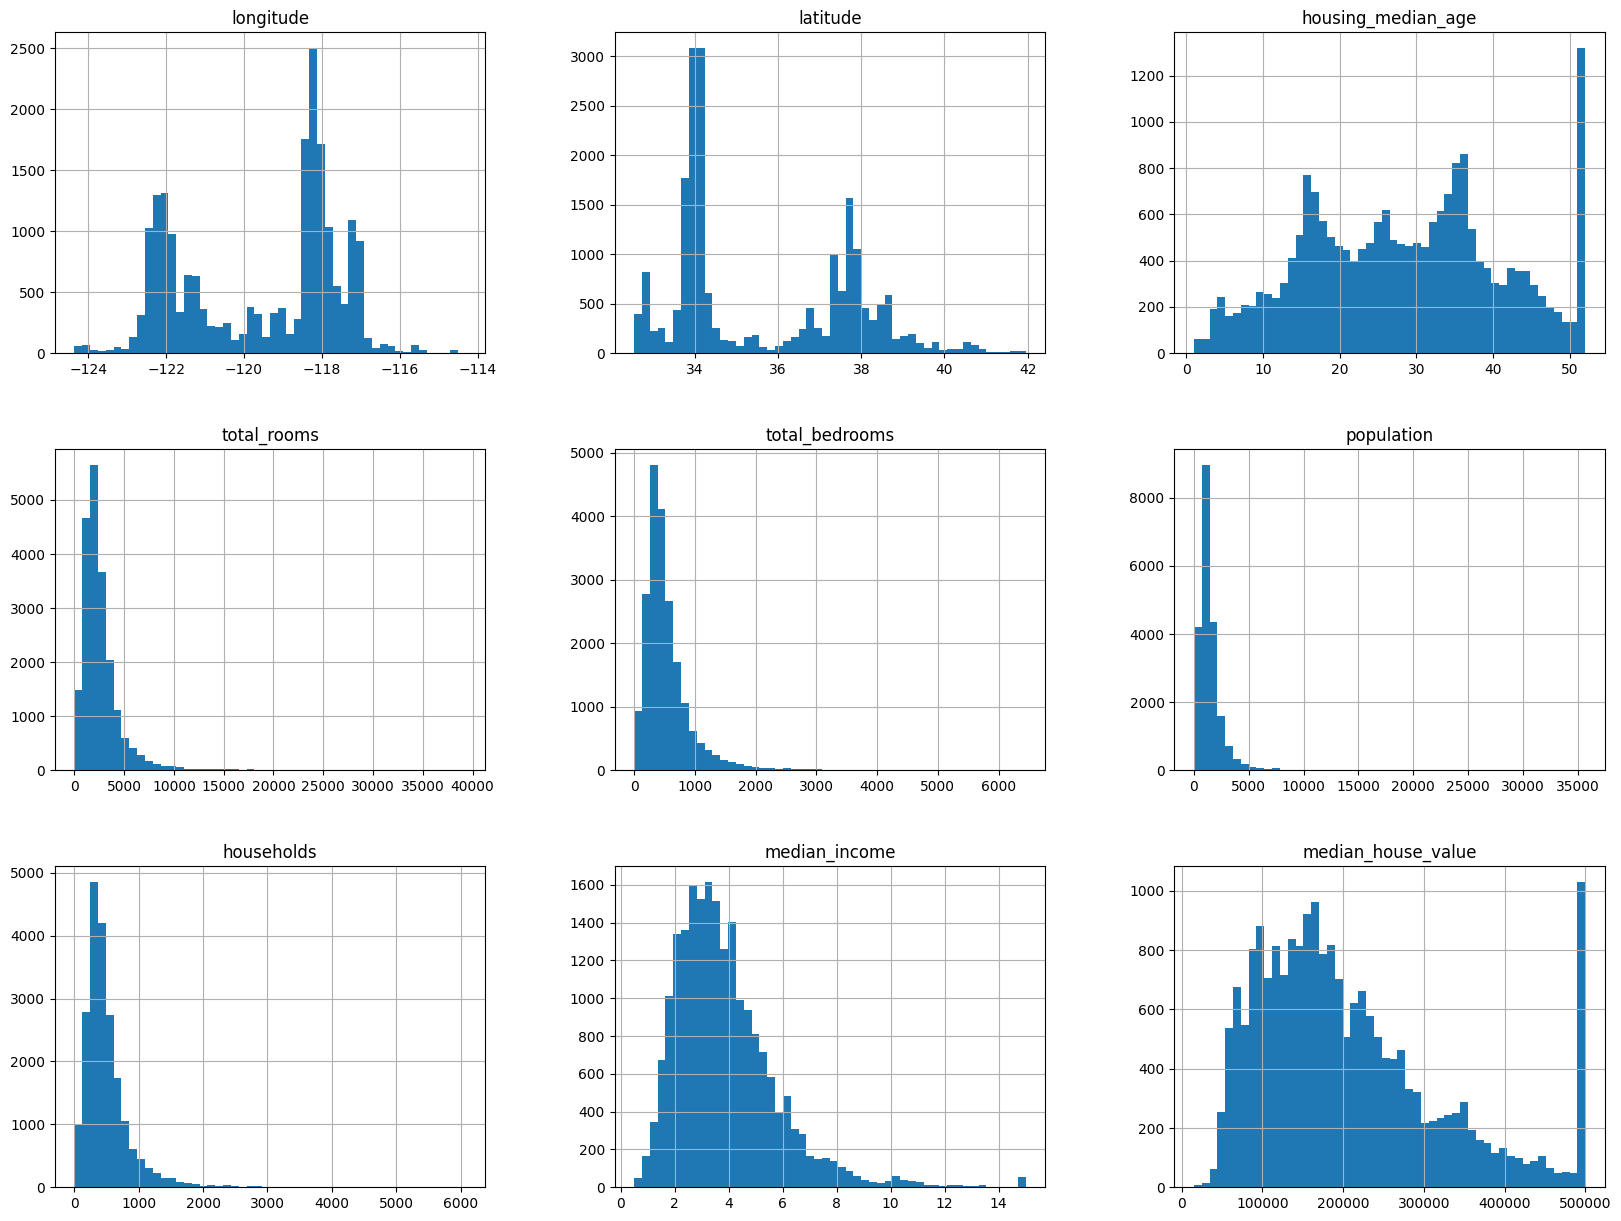

In [173]:
# plotting each numerical variable to visualize distribution of data
df.hist(bins=50, figsize=(20,15))
# note: using hist() method on the whole dataset plots a histogram for each numerical attribute in the dataset
plt.show()

**Note:**
1. Most of the data are skewed to the right, but they generally should be normally distributed (bell-shaped)
2. The graph for our lable (median_house_value) is capped at a certain value, which might pose an issue because the model might learn not to predict prices beyond the capped value(s). If predictions may go beyond those, consider:
    * collecting proper labels for the districts whose labels were capped
    * remove those districts from the training (and testing data set  since the system should not be evaluated poorly if it predicts values beyond $500,000)

### Dividing the data into training and test set
In general, it's not a good idea to  excessively searched and analyzed in order to find statistically significant patterns. Doing this leads to [Data Snooping Bias](https://www.wallstreetmojo.com/data-snooping-bias/), which might eventually lead to overfitting. 
It's a good idea to not look too much into test data to prevent tailoring the ML model to the test data by recognizing some patterns in the data. 

In [174]:
# test data are typically randomly generated at 20% of the dataset, see split_train_test() from helper_functions.py
train_set, test_set = split_train_test(df, 0.2)
print(len(train_set), "train +", len(test_set), "test")

16512 train + 4128 test


**Note:**
This works, but it is not perfect: running the program again will generate a different test set! Over time, we'll get to see the whole dataset, which is what we want to avoid
- One solution is to save the test set on the first run and then load it in subsequent runs
- Another option is to set the random number generator’s seed (e.g., `np.random.seed(42)`) before calling np.random.permutation(), so that it always generates the same shuffled indices.
However, but both these solutions will break next time we fetch an updated dataset.

A common solution is to use each instance’s identifier to decide whether or not it should go in the test set (assuming instances have a unique and immutable identifier). 
For example, you could compute a hash of each instance’s identifier, keep only the last byte of the hash, and put the instance in the test set if this value is lower or equal to
51 (~20% of 256). 
This ensures that the test set will remain consistent across multiple runs, even if you refresh the dataset. The new test set will contain 20% of the new instances, but it will not contain any instance that was previously in the training set

In [175]:
df_with_id = df.reset_index() # adds an `index` column
train_set, test_set = split_train_test_by_id(df_with_id, 0.2, "index")
print(len(train_set), "train +", len(test_set), "test")

16362 train + 4278 test


#### Spliting With SkLearn library

In [176]:
# this does same thing as previous approach but has some extra features and more efficient
train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)
print(len(train_set), "train +", len(test_set), "test")

16512 train + 4128 test


In [177]:
"""
This is an even much better approach that prevents sampling bias 
in the case the data is not large enough (stratified sampling)
"""

# creates an income category attribute by dividing the median income by 1.5 (to limit the number of income cate‐ gories), and rounding up using ceil (to have discrete categories),
df["income_cat"] = np.ceil(df["median_income"] / 1.5)
# merges all the categories greater than 5 into category 5:
df["income_cat"].where(df["income_cat"] < 5, 5.0, inplace=True)

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(df, df["income_cat"]):
    strat_train_set = df.loc[train_index]
    strat_test_set = df.loc[test_index]

df["income_cat"].value_counts() / len(df)

/var/folders/45/xrxp1w5d28gfw_8gw1_nzk8w0000gn/T/ipykernel_64640/1832244731.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["income_cat"].where(df["income_cat"] < 5, 5.0, inplace=True)


income_cat
3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: count, dtype: float64

In [178]:
# removing the income_cat attribute so the data is back to its original state
for set in (strat_train_set, strat_test_set):
 set.drop(["income_cat"], axis=1, inplace=True)

## In-Depth Look Into Data Through Visualisation and Drawing Insights

As discussed previously, we always want to put aside the test dataset and only explore deeply the training dataset
* If the training data is too large, we might also want to extra a set for exploration purposes
* This set, however is small so we can use it in full by making a copy

In [179]:
housing = strat_train_set.copy()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736,72100.0,INLAND
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373,279600.0,NEAR OCEAN
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750,82700.0,INLAND
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264,112500.0,NEAR OCEAN
20496,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964,238300.0,<1H OCEAN


### Visualizing Geographical Data

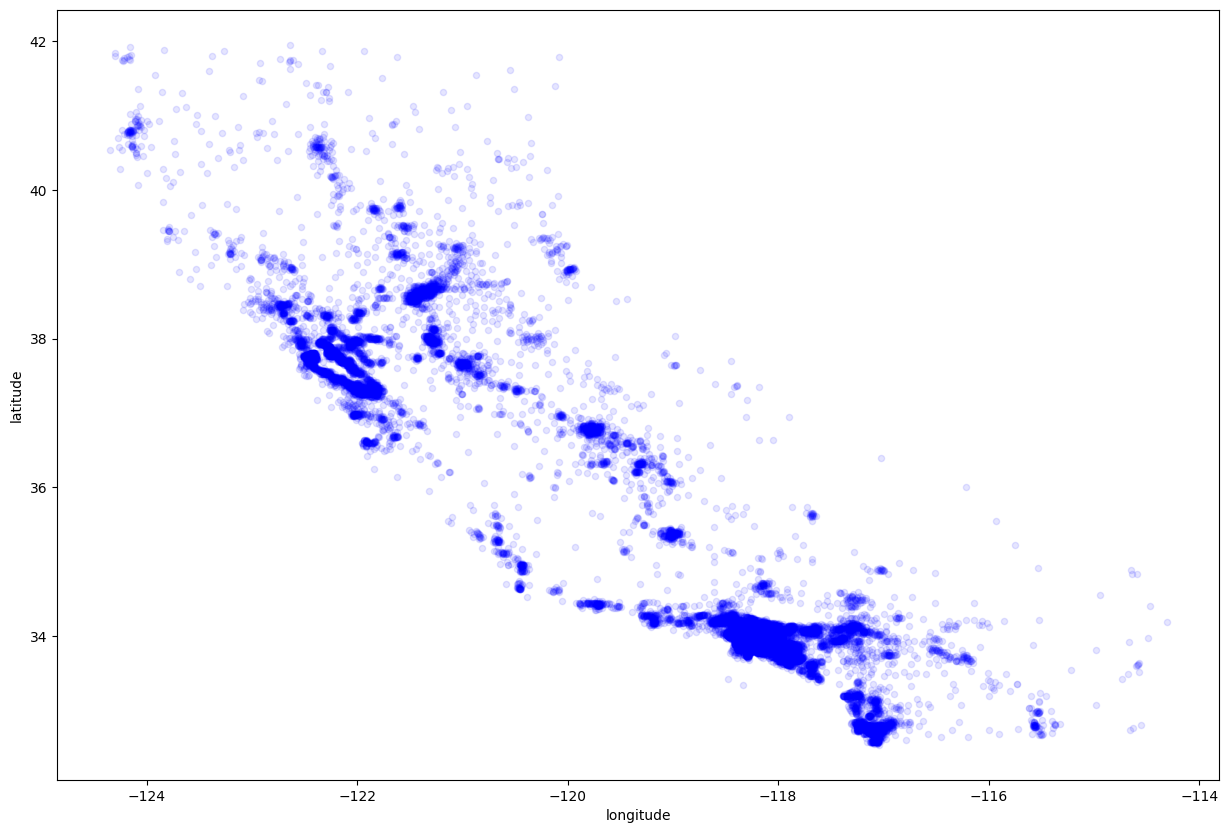

In [180]:
housing.plot(kind="scatter", x="longitude", y="latitude", color="blue", figsize=(15, 10), alpha=0.1) # alpha (opaciy) makes easy view
plt.show()

Now let’s look at the housing prices. 
The radius of each circle represents the district’s population (option s), and the color represents the price (option c). 
We will use a predefined color map (option cmap) called jet, which ranges from blue (low values) to red (high prices)

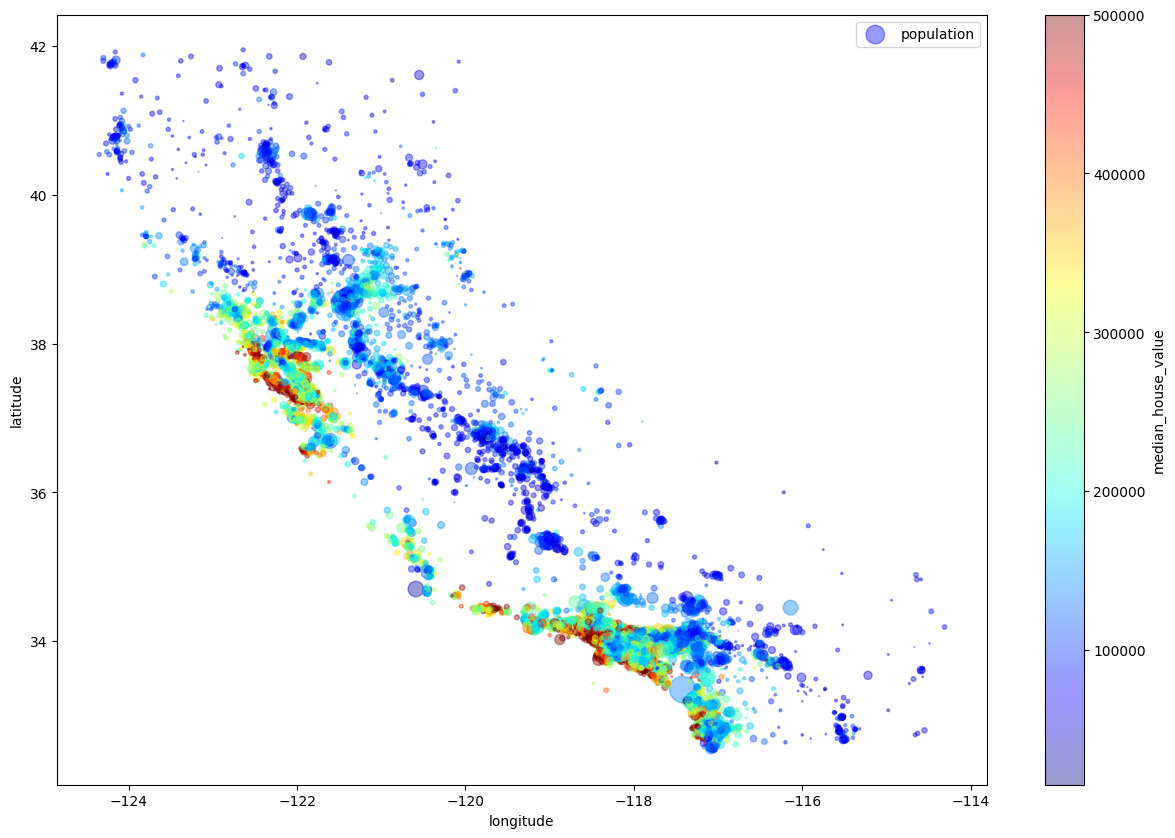

In [181]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
 s=housing["population"]/100, label="population", figsize=(15, 10),
 c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
)
plt.legend()
plt.show()

#### Looking For Correlations


In [182]:
# computes the correlation between every pair of attributes 
numeric_housing = housing.select_dtypes(include=[np.number]) # excludes non-number values
corr_matrix = numeric_housing.corr()
# see all correlations with median_house_value feature
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687151
total_rooms           0.135140
housing_median_age    0.114146
households            0.064590
total_bedrooms        0.047781
population           -0.026882
longitude            -0.047466
latitude             -0.142673
Name: median_house_value, dtype: float64

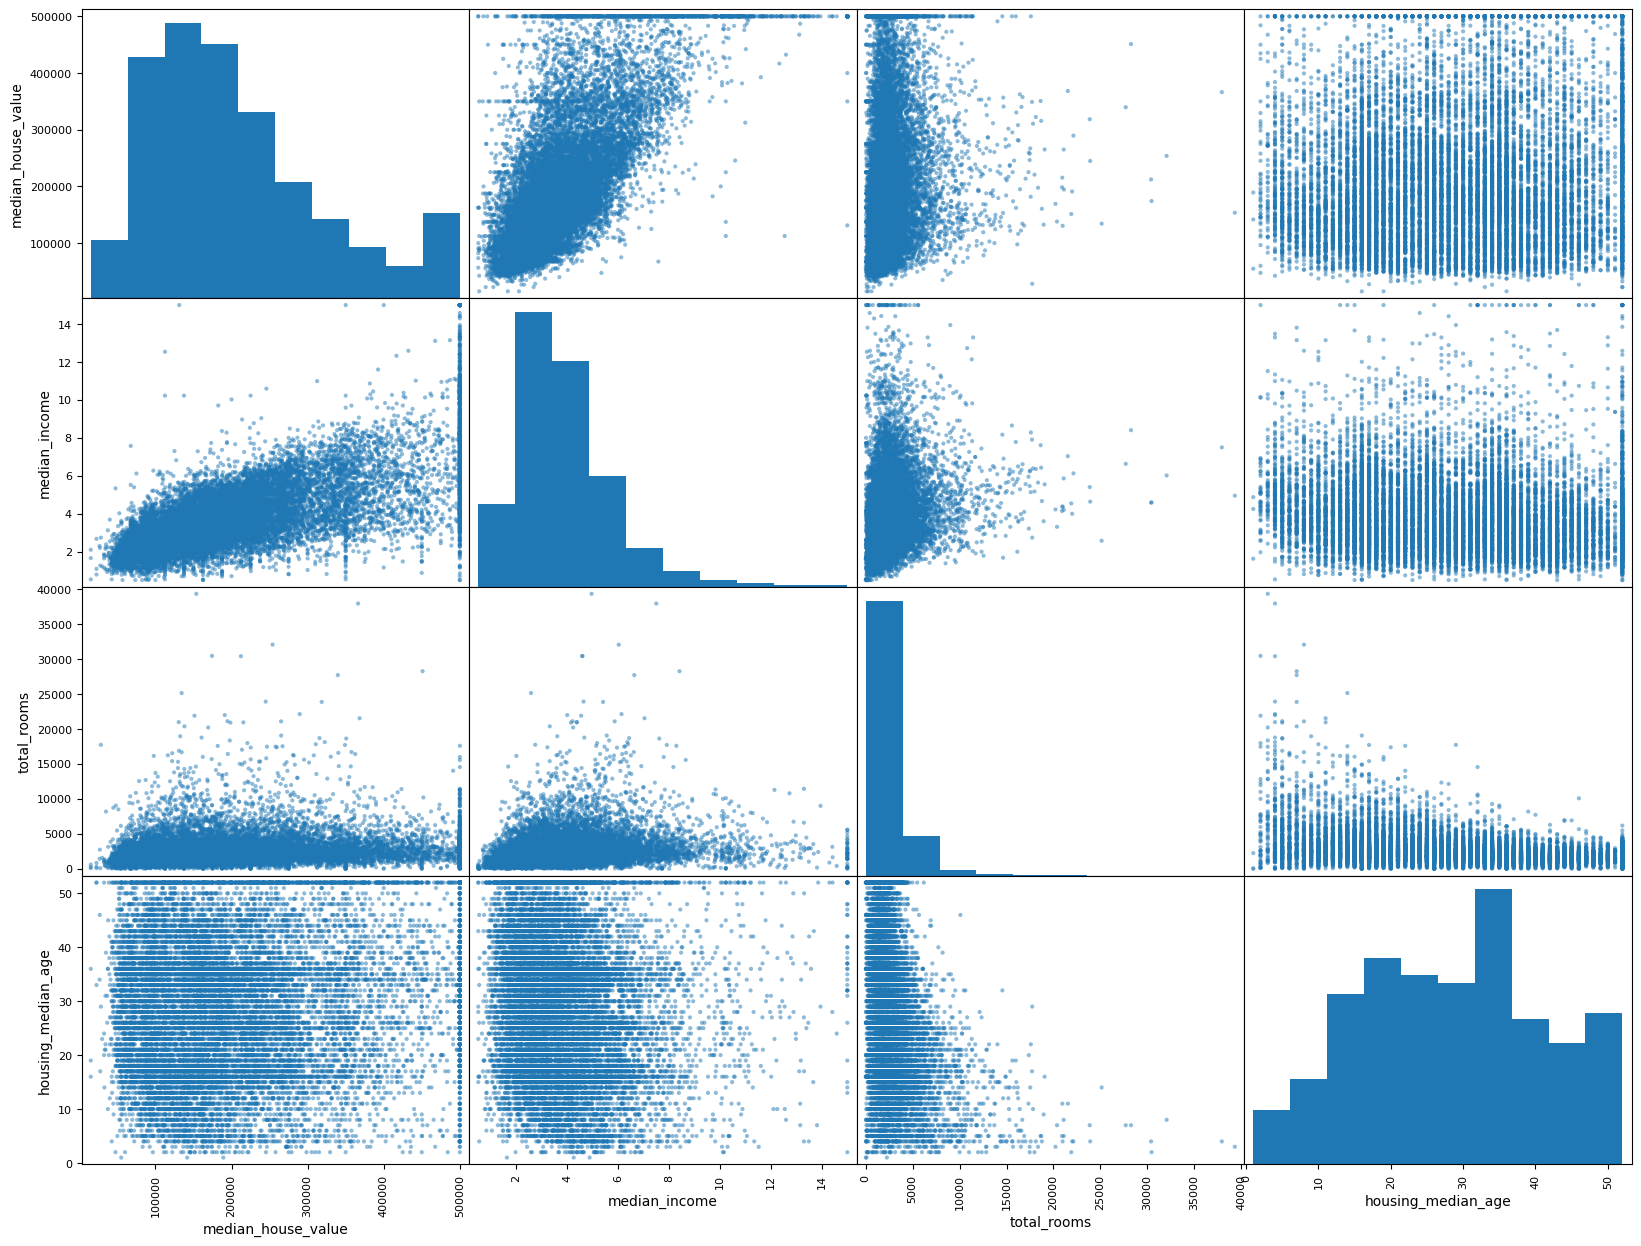

In [183]:
# plots every numerical attribute against every other numerical attribute
attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(20, 15))
plt.show()

#### Looking at the most promising attribute that could predict median house value

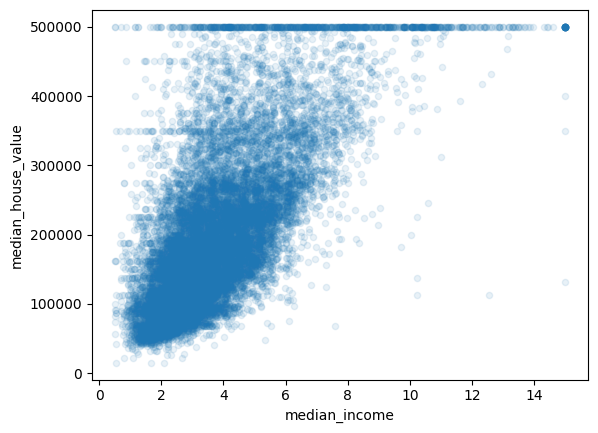

In [184]:
housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1); # semicolon to prevent printing the object

1. There's indeed a strong (positive) correlation between these two
2. The price cap noticed earlier is clearly visible ($500,000) at the top
3. But this plot reveals other less obvious straight lines: a horizontal line around $450,000, another around $350,000, perhaps one around $280,000, and a few more below that.
    - Removing the records corresponding to these could prevent the model from learning to produce some data quirks

### Exploring some interesting combinations of attributes
**Note**
- The total number of rooms in a district is not very useful if you don’t know how many households there are. What we really want is the number of rooms per household.
- The total number of bedrooms by itself is not very useful: we probably want to compare it to the number of rooms


In [185]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

In [186]:
numeric_housing = housing.select_dtypes(include=[np.number]) # excludes non-number values
corr_matrix = numeric_housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687151
rooms_per_household         0.146255
total_rooms                 0.135140
housing_median_age          0.114146
households                  0.064590
total_bedrooms              0.047781
population_per_household   -0.021991
population                 -0.026882
longitude                  -0.047466
latitude                   -0.142673
bedrooms_per_room          -0.259952
Name: median_house_value, dtype: float64

## Preparaing Data For ML Algorithms

In [187]:
# separating labels from predictors
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

### Cleaning

Missing Values in the set can be dropped, or filled with the median, mean or 0 using .fllna() method \
If using median, we must save the value for use in the test set as well

In [188]:
median = housing['total_bedrooms'].median()
housing['total_bedrooms'].fillna(median)

12655     797.0
15502     855.0
2908      310.0
14053     519.0
20496     646.0
          ...  
15174    1231.0
12661    1422.0
19263     166.0
19140     580.0
19773     222.0
Name: total_bedrooms, Length: 16512, dtype: float64

However, we can use SkLearn's imputer class to fill in missing values \
Moreover, we use the imputer because we cannot be sure if other attributes in new data would have missing values

In [189]:
imputer = SimpleImputer(strategy="median")
housing_num = housing.drop("ocean_proximity", axis=1)  # because imputer only works with numerical attributes
imputer.fit(housing_num)
print(housing_num.median().values)
print(imputer.statistics_)  # produces same result as line above

[-118.51      34.26      29.      2119.       433.      1164.
  408.         3.54155]
[-118.51      34.26      29.      2119.       433.      1164.
  408.         3.54155]


In [190]:
# using this “trained” imputer to transform the training set by replacing missing values by the learned medians
X = imputer.transform(housing_num)  # produces a plain Numpy array containing the transformed features.

# we can also do the fit and transform with a single method "fit_transform()" eg. imputer.fit_transform(housing_num)

In [191]:
housing_transformed = pd.DataFrame(X, columns=housing_num.columns)
housing_transformed

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
0,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736
1,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373
2,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750
3,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264
4,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964
...,...,...,...,...,...,...,...,...
16507,-117.07,33.03,14.0,6665.0,1231.0,2026.0,1001.0,5.0900
16508,-121.42,38.51,15.0,7901.0,1422.0,4769.0,1418.0,2.8139
16509,-122.72,38.44,48.0,707.0,166.0,458.0,172.0,3.1797
16510,-122.70,38.31,14.0,3155.0,580.0,1208.0,501.0,4.1964


#### Handling Text and Categorical Attributes


In [192]:
encoder = LabelEncoder()
housing_cat = housing["ocean_proximity"]
housing_cat_encoded = encoder.fit_transform(housing_cat)  # converts text attribute into numerical
print(encoder.classes_)
housing_cat_encoded

['<1H OCEAN' 'INLAND' 'ISLAND' 'NEAR BAY' 'NEAR OCEAN']


array([1, 4, 1, ..., 0, 0, 1])

This, however, creates issues when comparing relative values for example, categories 0 and 4 are more similar than categories 0 and 1 \
To fix this issue, a common solution is to create one binary attribute per category: one attribute equal to 1 when the category is \
“<1H OCEAN” (and 0 otherwise), another attribute equal to 1 when the category is “INLAND” (and 0 otherwise), and so on. \
This is called one-hot encoding, because only one attribute will be equal to 1 (hot), while the others will be 0 (cold)

In [193]:
encoder = OneHotEncoder()
housing_cat_1hot = encoder.fit_transform(housing_cat_encoded.reshape(-1,1)) # reshape because the encoder expects 2D while we're passing 1D
housing_cat_1hot.toarray()

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [197]:
# We can apply both transformations (from text categories to integer categories, then from integer categories to one-hot vectors) in one shot using the LabelBinarizer
encoder = LabelBinarizer()
housing_cat_1hot = encoder.fit_transform(housing_cat)
housing_cat_1hot

array([[0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1],
       [0, 1, 0, 0, 0],
       ...,
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0]])